1/1 [==============================] - 1s 719ms/step


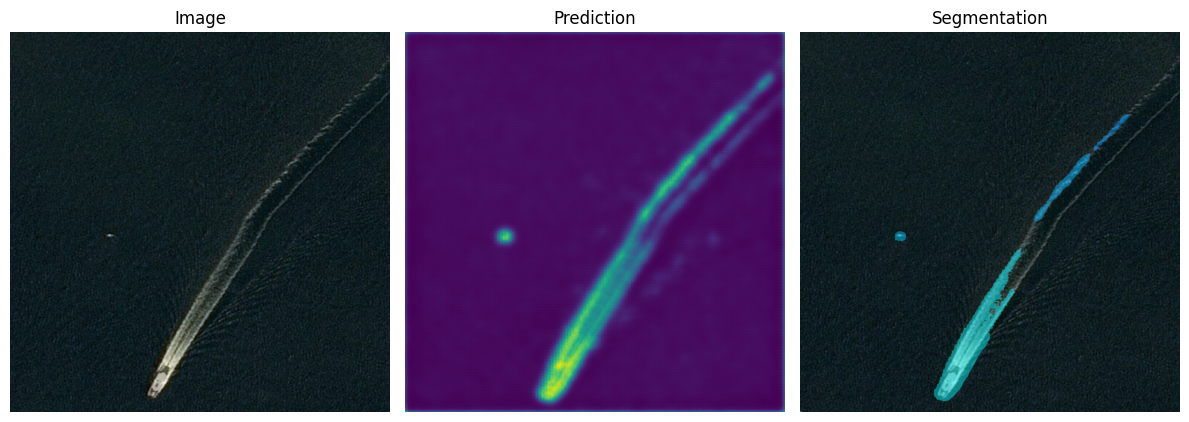

1/1 [==============================] - 0s 226ms/step


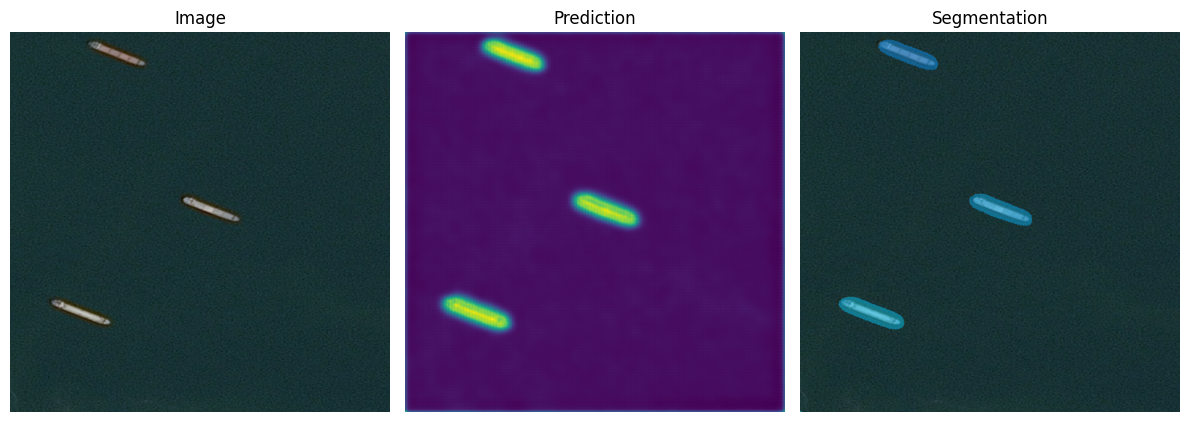

1/1 [==============================] - 0s 123ms/step


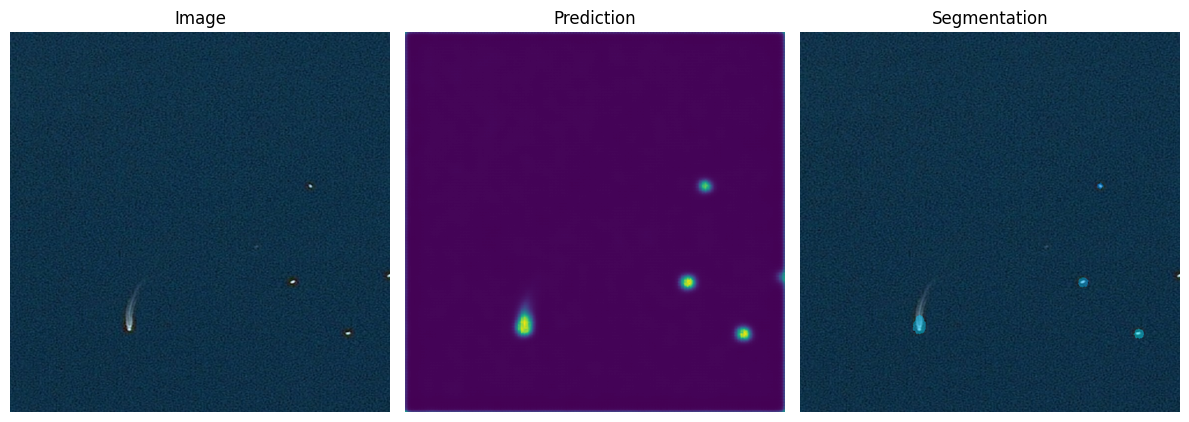

1/1 [==============================] - 0s 161ms/step


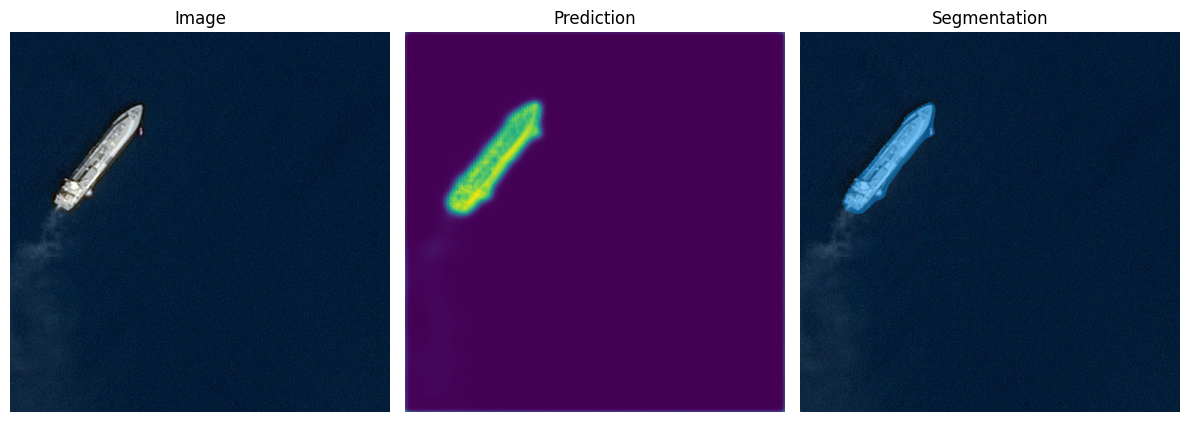

In [6]:
import os
import cv2
import random
import numpy as np
from PIL import Image
import tensorflow as tf
from matplotlib import pyplot as plt

from config import *
from utils.losses import *

# loading a model with custom scopes
with tf.keras.utils.custom_object_scope({'focal_loss': focal_loss, 'dice_score': dice_score}):
    trained_model = tf.keras.models.load_model('weights_and_models/best.h5')

# random images from test folder
# images = random.sample(os.listdir(TEST_DIR), 3)

# images with ships
images = TEST_IMAGES

def gen_pred(img, model):
    rgb_path = os.path.join(TEST_DIR,img)
    img = cv2.imread(rgb_path)
    img = cv2.resize(img, (768, 768))
    img = img[::IMG_SCALING[0], ::IMG_SCALING[1]]
    img = img / 255
    img = tf.expand_dims(img, axis=0)
    pred = model.predict(img)
    pred = np.squeeze(pred, axis=0)
    return Image.open(rgb_path), cv2.resize(pred, (768, 768))

def segmentation(img, pred, alpha=0.5):
    segmented_img = np.copy(img)
    threshold = 0.3

    labels = cv2.connectedComponentsWithStats(np.uint8(pred > threshold))[1]

    for label in range(1, labels.max() + 1):
        mask = labels == label
        if label < len(COLORS) + 1:
            color = COLORS[label - 1]
            segmented_img[mask] = color

    img_array = np.array(img)
    segmented_img = cv2.addWeighted(img_array, 1 - alpha, segmented_img, alpha, 0)

    return segmented_img

rows = 1
columns = 2
for i in range(len(images)):
    img, pred = gen_pred(images[i], trained_model)
    segmented_img = segmentation(img, pred)
    fig = plt.figure(figsize=(12, 9))

    rows = 1
    columns = 3

    fig.add_subplot(rows, columns, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Image")

    fig.add_subplot(rows, columns, 2)
    plt.imshow(pred)
    plt.axis('off')
    plt.title("Prediction")

    fig.add_subplot(rows, columns, 3)
    plt.imshow(segmented_img)
    plt.axis('off')
    plt.title("Segmentation")

    plt.tight_layout()
    plt.show()
